# GLM Module

One of the major changes in the 0.7.0 release of Nilearn was the inclusion of all the functionalities of [Nistats](https://nistats.github.io) `glm` module. 

<div class="alert alert-block alert-danger">
<b>Danger:</b> This module is experimental, hence subject to change in any future release.
</div>


<div class="alert alert-block alert-info">
<b>Tip:</b> In case you were previously using Nistats, we strongly recommand that you switch to Nilearn as Nistats isn't maintained anymore. Note that a guide to replacing Nistats imports to work in Nilearn is available on the documentation website <a href="https://nilearn.github.io/nistats_migration.html">here</a>.
</div>


## Objectives of this notebook

The GLM module provides a lot of functionalities that we cannot cover in reasonable time during this session. Our goal here is simply to advertise its existence, show how one can run standard analysis with this module, and provide some pointers to relevant ressources.

The outline is the following:

- <a href="#functionalities">Available functionalities</a>
- <a href="#first">First Level Models</a>
- <a href="#second">Second Level Models</a>

<span id="functionalities"></span>

## Available functionalities

The GLM module uses [Generalized Linear Model](https://en.wikipedia.org/wiki/Generalized_linear_model) to analyse functional MRI data. Nilearn offers functions to set up first- and second-level models, perform t-tests, multiple-comparisons correction and thresholding, and allows for the generation of html reports that detail the analyses performed and present thresholded results.

<div class="alert alert-block alert-info">
<b>Tip:</b> If you are not familiar with GLMs, we recommand that you browse through the Nilearn glm tutorial <a href="http://nilearn.github.io/glm/glm_intro.html#a-primer-on-bold-fmri-data-analysis">here</a></div>



First of all, make sure you have nilearn >= 0.7.0 installed:

In [1]:
import nilearn
print(nilearn.__version__)

0.7.2.dev


Note that you will get a warning when importing the GLM module since it is still considered experimental as its addition is very recent:

In [2]:
import nilearn.glm

/home/bertrand/mygit/nilearn/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


<span id="first"></span>

## First Level Models

### Description

First level models are, in essence, linear regression models run at the level of a single session or single subject. The model is applied on a voxel-wise basis, either on the whole brain or within a region of interest. The timecourse of each voxel is regressed against a predicted BOLD response created by convolving the haemodynamic response function (HRF) with a set of predictors defined within the design matrix.


### Example

This example is inspired from the documentation of Nilearn [here]https://nilearn.github.io/auto_examples/04_glm_first_level/plot_first_level_details.html#sphx-glr-auto-examples-04-glm-first-level-plot-first-level-details-py). We will follow the sequence of steps detailed above:

**1. Load sequence of fMRI volumes**

In [3]:
from nilearn.datasets import func
data = func.fetch_localizer_first_level()
fmri_img = data.epi_img

/home/bertrand/mygit/nilearn/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


Define the paradigm that will be used. Here, we just need to get the provided file.

This task, described in Pinel et al., BMC neuroscience 2007 probes basic functions, such as button presses with the left or right hand, viewing horizontal and vertical checkerboards, reading and listening to short sentences, and mental computations (subractions). Visual stimuli were displayed in four 250-ms epochs, separated by 100ms intervals (i.e., 1.3s in total). 

This task comprises 10 conditions:

* audio_left_hand_button_press: Left-hand three-times button press, indicated by auditory instruction
* audio_right_hand_button_press: Right-hand three-times button press, indicated by auditory instruction
* visual_left_hand_button_press: Left-hand three-times button press, indicated by visual instruction
* visual_right_hand_button_press: Right-hand three-times button press, indicated by visual instruction
* ... and 6 others

In [4]:
events_file = data['events']
import pandas as pd
events = pd.read_table(events_file)
events

,Unnamed: 0,Unnamed: 0.1,trial_type,onset,duration
0,0,0,visual_computation,0.000000,1.0
1,1,1,visual_computation,2.400000,1.0
2,2,2,horizontal_checkerboard,8.700000,1.0
3,3,3,audio_right_hand_button_press,11.400000,1.0
4,4,4,sentence_listening,15.000000,1.0
...,...,...,...,...,...
75,75,75,sentence_listening,284.399994,1.0
76,76,76,sentence_reading,288.000000,1.0
77,77,77,visual_right_hand_button_press,291.000000,1.0
78,78,78,sentence_listening,293.399994,1.0


## Running the model

Here specify the linear model. 
For that we mostly need to provide the repetition time (TR), here 2.4s.
We can also specify other parameters such as ahigh-pass filter (cutoff=.01hz). 
The .fit() functionality of FirstLevelModel function creates the design matrix and the beta maps.

In [5]:
from nilearn.glm.first_level import FirstLevelModel
first_level_model = FirstLevelModel(t_r=2.4, high_pass=.01)
first_level_model = first_level_model.fit(fmri_img, events=events)

/home/bertrand/mygit/nilearn/nilearn/glm/first_level/experimental_paradigm.py:88: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/home/bertrand/mygit/nilearn/nilearn/glm/first_level/experimental_paradigm.py:88: UserWarning: Unexpected column `Unnamed: 0.1` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "


Specification of a contrast.

For this example, we only specify one contrast, but many more might be defined dependeing on the research question. Note that the specification here is symbolic: the contrast is a string, containing an expression with plus and minus and condition names. Nilearn can interpret that.

In [6]:
contrasts = {'left - right button press':
                'audio_left_hand_button_press '
                '- audio_right_hand_button_press '
                '+ visual_left_hand_button_press '
                '- visual_right_hand_button_press'
            }

## Contrast estimation and plotting

Let us run the model and look at the outcome.


In [7]:
from nilearn.reporting import make_glm_report
report = make_glm_report(first_level_model, contrasts)
report

/home/bertrand/mygit/nilearn/nilearn/reporting/utils.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.savefig(


drift_model,cosine
drift_order,1
fir_delays,[0]
high_pass (Hz),0.01
hrf_model,glover
noise_model,ar1
scaling_axis,0
signal_scaling,True
slice_time_ref,0
smoothing_fwhm,None
standardize,False


<span id="second"></span>

## Second Level Models

Second level models in Nilearn are used to perform group-level analyses on fMRI data. Once individual subjects have been processed in a common space (e.g. MNI, Talairach, or subject average), the data can be grouped and statistical tests performed to make broader inferences on fMRI activity. Some common second level models are one-sample (unpaired or paired) and two-sample t-tests.

For simplicity, we download here a list of left vs right button press contrasts from a localizer dataset:

In [8]:
from nilearn.datasets import fetch_localizer_contrasts

n_subjects = 16

sample_vertical = fetch_localizer_contrasts(["vertical checkerboard"], 
                                            n_subjects, 
                                            get_tmaps=True)
sample_horizontal = fetch_localizer_contrasts(["horizontal checkerboard"], 
                                              n_subjects, 
                                              get_tmaps=True)
second_level_input = sample_vertical['cmaps'] + sample_horizontal['cmaps']

/home/bertrand/.local/lib/python3.8/site-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


Next, we model the effect of conditions (sample 1 vs sample 2).

In [9]:
import numpy as np
condition_effect = np.hstack(([1] * n_subjects, [- 1] * n_subjects))
condition_effect

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

Subsequently, we can model the subject effect: each subject is observed in sample 1 and sample 2.

In [10]:
subjects = ['S%02d' % i for i in range(1, n_subjects + 1)]
subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))

We then assemble those in a design matrix:

In [11]:
design_matrix = pd.DataFrame(
                    np.hstack((condition_effect[:, np.newaxis], 
                               subject_effect)),
                    columns=['vertical vs horizontal'] + subjects)
design_matrix.head(3)

,vertical vs horizontal,S01,S02,S03,S04,S05,S06,S07,S08,S09,S10,S11,S12,S13,S14,S15,S16
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As for first level design matrices, we can plot this matrix using the function `plot_design_matrix`:

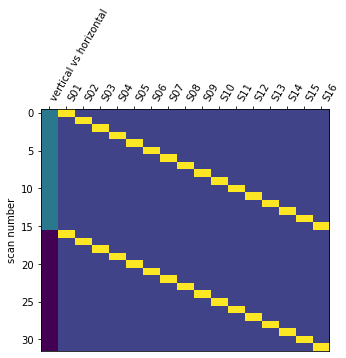

In [12]:
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt
plot_design_matrix(design_matrix)
plt.tight_layout()

Initialize the second level model and fit:

In [13]:
from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel().fit(second_level_input, 
                                            design_matrix=design_matrix)

Estimating the contrast is very simple. We can just provide the column name of the design matrix:

In [14]:
z_map = second_level_model.compute_contrast('vertical vs horizontal',
                                            output_type='z_score')

We threshold the second level contrast and plot it:

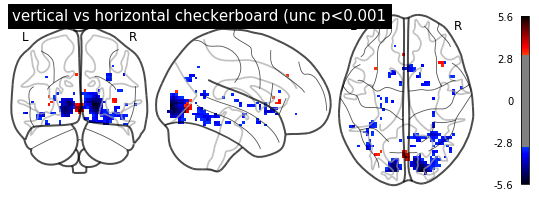

In [15]:
from nilearn.plotting import plot_glass_brain

threshold = 3.1  # correponds to  p < .001, uncorrected

plot_glass_brain(z_map, 
                 threshold=threshold, 
                 colorbar=True, 
                 plot_abs=False,
                 title='vertical vs horizontal checkerboard (unc p<0.001')

Unsurprisingly, we see activity in the primary visual cortex, both positive and negative.

### References

- [Simple example of two-session fMRI model fitting](http://nilearn.github.io/auto_examples/04_glm_first_level/plot_fiac_analysis.html#sphx-glr-auto-examples-04-glm-first-level-plot-fiac-analysis-py)
- [Single-subject data (two sessions) in native space](http://nilearn.github.io/auto_examples/04_glm_first_level/plot_spm_multimodal_faces.html#sphx-glr-auto-examples-04-glm-first-level-plot-spm-multimodal-faces-py)
- Seed based GLM: [Default Mode Network extraction of AHDH dataset](http://nilearn.github.io/auto_examples/04_glm_first_level/plot_adhd_dmn.html#sphx-glr-auto-examples-04-glm-first-level-plot-adhd-dmn-py)